In [1]:
### Notebook to reformat data from old codebase into new codebase formats

In [1]:
from datasets import Dataset, DatasetDict, concatenate_datasets
from setretrieval.utils.utils import pickload, pickdump
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter, defaultdict
import random
from datasets import Dataset, DatasetDict, load_dataset
from pylate import evaluation, utils
from transformers import AutoTokenizer


/accounts/projects/sewonm/prasann/.conda/envs/scaling7/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


: 

In [2]:
# load fiqa, bright bio corpuses
fiqa = Dataset.load_from_disk("../propercache/data/datastores/fiqacorpus")
brightbio = Dataset.load_from_disk("../propercache/data/datastores/bright_biology")

In [ ]:
# msmarco trainset load: 
msmarco = Dataset.load_from_disk("../propercache/data/colbert_training/msmarco_100k")

In [3]:
modernberttok = AutoTokenizer.from_pretrained("answerdotai/ModernBERT-base")

In [ ]:
# tokenize both corpora, get average length of text
fiqa_toks = [len(modernberttok.encode(q['text'])) for q in tqdm(fiqa)]
bright_toks = [len(modernberttok.encode(q['text'])) for q in tqdm(brightbio)]

 20%|█▉        | 11302/57638 [00:04<00:17, 2688.17it/s]


KeyboardInterrupt: 

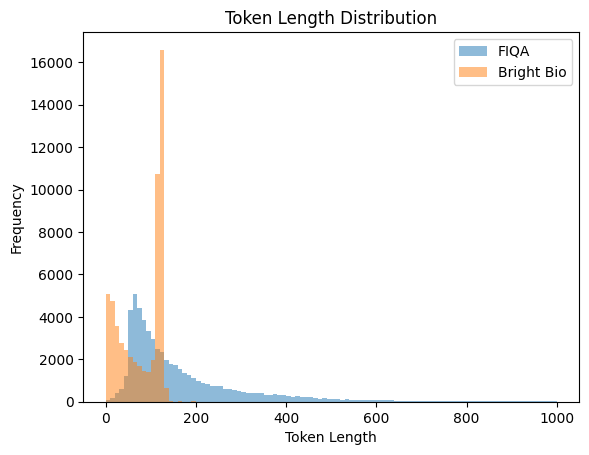

In [7]:
plt.hist(fiqa_toks, bins=100, range=(0, 1000), alpha=0.5, label='FIQA')
plt.hist(bright_toks, bins=100, range=(0, 1000), alpha=0.5, label='Bright Bio')
plt.xlabel('Token Length')
plt.ylabel('Frequency')
plt.title('Token Length Distribution')
plt.legend()
plt.show()

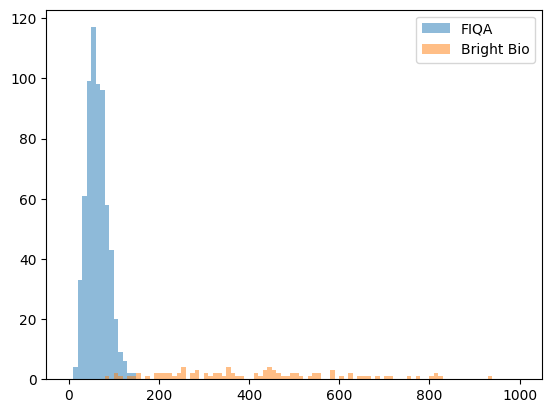

In [ ]:
fiqaqs = Dataset.load_from_disk("../propercache/data/evalsets/fiqa_testset")
brightqs = Dataset.load_from_disk("../propercache/data/evalsets/bright_biology")
fiqaqs = [len(q['question']) for q in fiqaqs]
brightqs = [len(q['question']) for q in brightqs]
plt.hist(fiqaqs, bins=100, range=(0, 1000), alpha=0.5, label='FIQA')
plt.hist(brightqs, bins=100, range=(0, 1000), alpha=0.5, label='Bright Bio')
plt.legend()
plt.show()

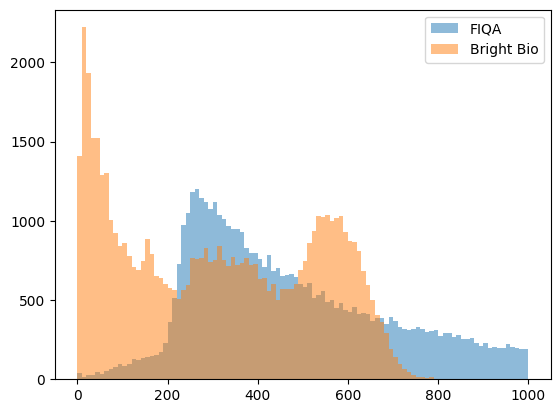

In [6]:
fiqlens = [len(d['text']) for d in fiqa]
brightlen = [len(d['text']) for d in brightbio]
plt.hist(fiqlens, bins=100, range=(0, 1000), alpha=0.5, label='FIQA')
plt.hist(brightlen, bins=100, range=(0, 1000), alpha=0.5, label='Bright Bio')
plt.legend()
plt.show()



In [3]:
train = load_dataset(
    path="lightonai/ms-marco-en-bge",
    name="train",
)

queries = load_dataset(
    path="lightonai/ms-marco-en-bge",
    name="queries",
)

documents = load_dataset(
    path="lightonai/ms-marco-en-bge",
    name="documents",
)

In [4]:
train['train'] = train['train'].select(range(1000))

In [10]:
train['train'][0]

{'query_id': '121352',
 'document_ids': ['2259784',
  '4923159',
  '40211',
  '1545154',
  '8527175',
  '5101119',
  '2912794',
  '7070778',
  '2912791',
  '2912788',
  '7480161',
  '8527174',
  '7568754',
  '2192171',
  '2912790',
  '4923158',
  '2038387',
  '7913763',
  '1680242',
  '2259780',
  '8439701',
  '160758',
  '3410567',
  '7135096',
  '7577848',
  '1771376',
  '5561503',
  '1771379',
  '40217',
  '4156000',
  '2838718',
  '7675730'],
 'scores': [0.2343463897705078,
  0.639204204082489,
  0.3806908428668976,
  0.5623092651367188,
  0.8051995635032654,
  0.7690711617469788,
  0.9248138666152954,
  0.7148785591125488,
  1.0,
  0.595752477645874,
  0.7134138941764832,
  0.5686561465263367,
  0.5022580027580261,
  0.2757231891155243,
  0.7036494612693787,
  0.47369706630706787,
  0.0,
  0.2561332881450653,
  0.13742676377296448,
  0.05492493510246277,
  0.4321982264518738,
  0.42560723423957825,
  0.29073598980903625,
  0.2957402765750885,
  0.2918345034122467,
  0.178933233022

In [11]:
train.set_transform(
    utils.KDProcessing(queries=queries, documents=documents).transform,
)

In [14]:
train['train'][0]

{'query_id': '121352',
 'document_ids': ['2259784',
  '4923159',
  '40211',
  '1545154',
  '8527175',
  '5101119',
  '2912794',
  '7070778',
  '2912791',
  '2912788',
  '7480161',
  '8527174',
  '7568754',
  '2192171',
  '2912790',
  '4923158',
  '2038387',
  '7913763',
  '1680242',
  '2259780',
  '8439701',
  '160758',
  '3410567',
  '7135096',
  '7577848',
  '1771376',
  '5561503',
  '1771379',
  '40217',
  '4156000',
  '2838718',
  '7675730'],
 'scores': [0.2343463897705078,
  0.639204204082489,
  0.3806908428668976,
  0.5623092651367188,
  0.8051995635032654,
  0.7690711617469788,
  0.9248138666152954,
  0.7148785591125488,
  1.0,
  0.595752477645874,
  0.7134138941764832,
  0.5686561465263367,
  0.5022580027580261,
  0.2757231891155243,
  0.7036494612693787,
  0.47369706630706787,
  0.0,
  0.2561332881450653,
  0.13742676377296448,
  0.05492493510246277,
  0.4321982264518738,
  0.42560723423957825,
  0.29073598980903625,
  0.2957402765750885,
  0.2918345034122467,
  0.178933233022

In [15]:
newdata = Dataset.from_list([r for r in train['train']])

In [17]:
DatasetDict({"train": newdata}).save_to_disk("../propercache/data/colbert_training/msmarco_bge_train_1k")

Saving the dataset (1/1 shards): 100%|██████████| 1000/1000 [00:00<00:00, 8594.83 examples/s]


In [7]:
len(train['train'][0]['document_ids'])

32

In [2]:
tok = AutoTokenizer.from_pretrained("Qwen/Qwen3-Embedding-0.6B")

In [6]:
tok.pad_token_id

151643

In [ ]:
def beir_to_retrieval(corpus, queries, qrels):
    # convert from beir format to a corpus and an eval set with question and pos_chunks
    print(corpus[0], queries[0], qrels[0])
    cids2inds = {c['_id']: i for i, c in enumerate(corpus)}
    qids2inds = {q['_id']: i for i, q in enumerate(queries)}
    queries2poschunks = defaultdict(list)
    for q in qrels:
        queries2poschunks[queries[qids2inds[q['query-id']]]['text']].append(corpus[cids2inds[q['corpus-id']]]['text'])
    evalset = Dataset.from_list([{'question': q, "pos_chunks": v} for q, v in queries2poschunks.items()])
    return evalset

def process_nano_dset(name="zeta-alpha-ai/NanoMSMARCO"):
    corpus, queries, qrels = load_dataset(name, 'corpus'), load_dataset(name, 'queries'), load_dataset(name, 'qrels')
    evalset = beir_to_retrieval(corpus['train'], queries['train'], qrels['train'])
    return evalset, corpus

ev, corp = process_nano_dset()

{'_id': '2004', 'text': 'n (Brit. history) a local government committee composed of magistrates and representatives of the county borough council responsible for the efficiency of the local police force. English Collins Dictionary-English Definition & Thesaurus &nbsp.'} {'_id': '994479', 'text': 'which health care system provides all citizens or residents with equal access to health care services'} {'query-id': '994479', 'corpus-id': '7275120'}


In [38]:
corp['train']

Dataset({
    features: ['_id', 'text'],
    num_rows: 5043
})

In [39]:
ev.save_to_disk("../propercache/data/evalsets/nanomsmarco_evalset")
corp['train'].save_to_disk("../propercache/data/datastores/nanomsmarco_corpus")
#!wget https://dl.fbaipublicfiles.com/dpr/data/retriever/nq-test.qa.csv

Saving the dataset (1/1 shards): 100%|██████████| 5043/5043 [00:00<00:00, 196545.89 examples/s]


In [42]:
# msmarco
msmarco = DatasetDict.load_from_disk("../propercache/data/colbert_training/msmarco_500k")
msmarco['train'] = msmarco['train'].select(range(100000))
msmarco.save_to_disk("../propercache/data/colbert_training/msmarco_100k")

Saving the dataset (1/1 shards): 100%|██████████| 2931/2931 [00:00<00:00, 110330.85 examples/s]


In [15]:
#!wget https://dl.fbaipublicfiles.com/dpr/data/retriever/nq-test.qa.csv
dprtest = Dataset.from_csv("nq-test.qa.csv", delimiter="\t")

Generating train split: 3610 examples [00:00, 162854.93 examples/s]

In [16]:
dprtest[1]

{'question': 'when is the next deadpool movie being released',
 'pos_chunks': "['May 18 , 2018']"}

In [ ]:
# !wget https://public.ukp.informatik.tu-darmstadt.de/thakur/BEIR/datasets/fiqa.zip
# !unzip fiqa.zip
# !rm fiqa.zip
# !mv fiqa ../propercache/data/datastores/

In [52]:
fiqaqrelstest = Dataset.from_csv("../propercache/data/datastores/fiqa/qrels/test.tsv", sep="\t")
fiqaqrelstrain = Dataset.from_csv("../propercache/data/datastores/fiqa/qrels/train.tsv", sep="\t")
fiqaqrelsdev = Dataset.from_csv("../propercache/data/datastores/fiqa/qrels/dev.tsv", sep="\t")
fiqaqueries = Dataset.from_json("../propercache/data/datastores/fiqa/queries.jsonl")
fiqapassages = Dataset.from_json("../propercache/data/datastores/fiqa/corpus.jsonl")
queriesind2id = {int(q['_id']): i for i, q in enumerate(fiqaqueries)}
docsind2id = {int(d['_id']): i for i, d in enumerate(fiqapassages)}
print(fiqaqueries[queriesind2id[fiqaqrelstest[0]['query-id']]])
print(fiqapassages[docsind2id[fiqaqrelstest[0]['corpus-id']]])

{'_id': '8', 'text': 'How to deposit a cheque issued to an associate in my business into my business account?', 'metadata': {}}
{'_id': '566392', 'title': '', 'text': 'Have the check reissued to the proper payee.', 'metadata': {}}


In [ ]:
# make fiqa test set in our format
queries2poschunks = defaultdict(list)
for row in fiqaqrelstest:
    queries2poschunks[fiqaqueries[queriesind2id[row['query-id']]]['text']].append(fiqapassages[docsind2id[row['corpus-id']]]['text'])
evalset = Dataset.from_list([{'question': q, "pos_chunks": v} for q, v in queries2poschunks.items()])
# evalset.save_to_disk("../propercache/data/evalsets/fiqa_testset")
# Dataset.from_list(fiqapassages).save_to_disk("../propercache/data/datastores/fiqacorpus")

In [53]:
def qrels_to_traindata(qrels):
    tdata = []
    for q in qrels: 
        tdata.append({
            'query': fiqaqueries[queriesind2id[q['query-id']]]['text'],
            'positive': fiqapassages[docsind2id[q['corpus-id']]]['text'],
            'negative': fiqapassages[random.randint(0, len(fiqapassages) - 1)]['text']
        })
    return Dataset.from_list(tdata)

fiqa_train = DatasetDict({
    'train': qrels_to_traindata(fiqaqrelstrain), 
    'test': qrels_to_traindata(fiqaqrelsdev)
})


In [56]:
fiqa_train.save_to_disk("../propercache/data/colbert_training/fiqa_train")

Saving the dataset (1/1 shards): 100%|██████████| 1238/1238 [00:00<00:00, 45866.92 examples/s]


In [62]:
fiqa_train['train'][5]

{'query': '“Business day” and “due date” for bills',
 'positive': "It's likely that your bill always shows the 24th as the due date. Their system is programmed to maintain that consistency regardless of the day of the week that falls on. When the 24th isn't a business day it is good to error on the side of caution and use the business day prior.  It would have accepted using their system with a CC payment on the 24th because that goes through their automated system. I would hazard a guess that because your payment was submitted through your bank and arrived on the 23rd it wasn't credited because a live person would have needed to be there to do it and their live people probably don't work weekends. I do much of my bill paying online and have found it easiest to just build a couple days of fluff into the schedule to avoid problems like this. That said, if you call them and explain the situation it is likely that they will credit the late charge back to you.",
 'negative': "Often times, 

(array([404., 103.,  85.,  20.,  13.,  11.,   6.,   3.,   1.,   2.]),
 array([ 1. ,  2.4,  3.8,  5.2,  6.6,  8. ,  9.4, 10.8, 12.2, 13.6, 15. ]),
 <BarContainer object of 10 artists>)

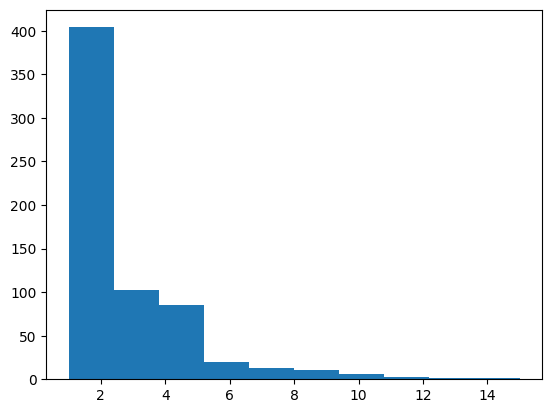

In [43]:
plt.hist([len(v) for v in queries2poschunks.values()])

--2026-01-30 15:41:56--  https://dl.fbaipublicfiles.com/dpr/data/retriever/nq-test.qa.csv
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 2600:9000:291e:f400:13:6e38:acc0:93a1, 2600:9000:291e:8c00:13:6e38:acc0:93a1, 2600:9000:291e:8800:13:6e38:acc0:93a1, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|2600:9000:291e:f400:13:6e38:acc0:93a1|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 296949 (290K) [text/plain]
Saving to: ‘nq-test.qa.csv.1’

nq-test.qa.csv.1    100%[===================>] 289.99K  --.-KB/s    in 0.03s   

2026-01-30 15:41:57 (10.2 MB/s) - ‘nq-test.qa.csv.1’ saved [296949/296949]



In [3]:
Dataset.from_csv("nq-test.qa.csv")

NameError: name 'Dataset' is not defined

In [25]:
fiqanegs = load_dataset("ssktora/fiqa-train-bm25-pyserini")

In [34]:
max(len(x['positive_passages']) for x in fiqanegs['train'])

23

In [27]:
fiqanegs['train'][0]

{'query_id': '0',
 'query': 'What is considered a business expense on a business trip?',
 'positive_passages': [{'docid': '18850',
   'title': '',
   'text': 'The IRS Guidance pertaining to the subject.  In general the best I can say is your business expense may be deductible.  But it depends on the circumstances and what it is you want to deduct. Travel Taxpayers who travel away from home on business may deduct related   expenses, including the cost of reaching their destination, the cost   of lodging and meals and other ordinary and necessary expenses.   Taxpayers are considered “traveling away from home” if their duties   require them to be away from home substantially longer than an   ordinary day’s work and they need to sleep or rest to meet the demands   of their work. The actual cost of meals and incidental expenses may be   deducted or the taxpayer may use a standard meal allowance and reduced   record keeping requirements. Regardless of the method used, meal   deductions are g

In [37]:
alldata = []
for row in tqdm(fiqanegs['train'], desc="Converting FIQA train to retrieval format"):
    for p in row['positive_passages']:
        alldata.append({
            'query': row['query'],
            'positive': p['text'],
            'negative': random.choice(row['negative_passages'])['text']
        })
fiqanewtrain = Dataset.from_list(alldata)

Converting FIQA train to retrieval format: 100%|██████████| 5500/5500 [00:01<00:00, 5201.82it/s]


In [40]:
fiqadict = DatasetDict({
    "train": fiqanewtrain.select(range(500, len(fiqanewtrain))),
    "test": fiqanewtrain.select(range(500))
})
fiqadict.save_to_disk("../propercache/data/colbert_training/fiqa_train_retrieval")

Saving the dataset (1/1 shards): 100%|██████████| 500/500 [00:00<00:00, 26422.81 examples/s]


In [4]:
nq = load_dataset("sentence-transformers/natural-questions")

In [3]:
nq_hardnegs = load_dataset("tomaarsen/natural-questions-hard-negatives", "triplet-5")

Generating train split: 100%|██████████| 96658/96658 [00:05<00:00, 16782.52 examples/s]


In [1]:
!wget https://dl.fbaipublicfiles.com/dpr/data/retriever/nq-test.qa.csv

--2026-01-30 14:38:11--  https://dl.fbaipublicfiles.com/dpr/data/retriever/nq-test.qa.csv
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 2600:9000:291e:c00:13:6e38:acc0:93a1, 2600:9000:291e:1000:13:6e38:acc0:93a1, 2600:9000:291e:8400:13:6e38:acc0:93a1, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|2600:9000:291e:c00:13:6e38:acc0:93a1|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 296949 (290K) [text/plain]
Saving to: ‘nq-test.qa.csv’

nq-test.qa.csv      100%[===================>] 289.99K  --.-KB/s    in 0.04s   

2026-01-30 14:38:11 (7.97 MB/s) - ‘nq-test.qa.csv’ saved [296949/296949]



In [7]:
nq_hardnegs['train'][0]

{'query': 'when did richmond last play in a preliminary final',
 'answer': "Richmond Football Club Richmond began 2017 with 5 straight wins, a feat it had not achieved since 1995. A series of close losses hampered the Tigers throughout the middle of the season, including a 5-point loss to the Western Bulldogs, 2-point loss to Fremantle, and a 3-point loss to the Giants. Richmond ended the season strongly with convincing victories over Fremantle and St Kilda in the final two rounds, elevating the club to 3rd on the ladder. Richmond's first final of the season against the Cats at the MCG attracted a record qualifying final crowd of 95,028; the Tigers won by 51 points. Having advanced to the first preliminary finals for the first time since 2001, Richmond defeated Greater Western Sydney by 36 points in front of a crowd of 94,258 to progress to the Grand Final against Adelaide, their first Grand Final appearance since 1982. The attendance was 100,021, the largest crowd to a grand final sin

In [14]:
testcorpsize = 10000
testcorpus = []
testset = []
for row in nq_hardnegs['train'].select(range(testcorpsize)):
    testcorpus.extend([row['answer']]+ [row[f'negative_{i}'] for i in range(1, 6)])
    testset.append({
        'question': row['query'],
        'pos_chunks': [row['answer']],
    })
testset = Dataset.from_list(testset)
testcorpus = Dataset.from_dict({"text": list(set(testcorpus))})

In [16]:
trainset = []
pairs_per_question = 2
for row in nq_hardnegs['train'].select(range(testcorpsize, len(nq_hardnegs['train']))):
    for i in range(pairs_per_question):
        trainset.append({
            'query': row['query'],
            'positive': row['answer'],
            'negative': row[f"negative_{i+1}"]
        })
trainset = Dataset.from_list(trainset)
trainset = DatasetDict({
    "test": trainset.select(range(1000)), 
    "train": trainset.select(range(1000, len(trainset)))
})

In [24]:
testset.select(range(1000)).save_to_disk("../propercache/data/evalsets/nq_hardnegs_testset")
testcorpus.save_to_disk("../propercache/data/datastores/nq_hardnegs_testset")
trainset.save_to_disk("../propercache/data/colbert_training/nq_hardnegs_trainset")

Saving the dataset (1/1 shards): 100%|██████████| 172316/172316 [00:01<00:00, 88509.44 examples/s]  


In [22]:
trainset['train'][4]

{'query': 'green day wake me up when september ends song meaning',
 'positive': 'Wake Me Up When September Ends "Wake Me Up When September Ends" was written by Green Day frontman Billie Joe Armstrong about his father, who died of cancer in September 1982 when Billie Joe was ten.[1][2] Armstrong, at one point, dubbed the song the most autobiographical he had written to that point, considering it "therapeutic" but also difficult to perform.[3]',
 'negative': 'Wake Me Up (Avicii song) "Wake Me Up" is a song by Swedish DJ and record producer Avicii, released as the lead single from his debut studio album True, released on CD and cassette by PRMD Music, Lava Records and Sony Music\'s Columbia Records on 17 June 2013. "Wake Me Up" was written by Avicii, Mike Einziger, and Aloe Blacc. American soul singer Aloe Blacc provides uncredited vocals for the track[2][3] and Mike Einziger of Incubus provides acoustic guitar. Avicii introduced "Wake Me Up!" for the first time live on stage at the Ultra

In [6]:
nq['train'][0]

{'query': 'when did richmond last play in a preliminary final',
 'answer': "Richmond Football Club Richmond began 2017 with 5 straight wins, a feat it had not achieved since 1995. A series of close losses hampered the Tigers throughout the middle of the season, including a 5-point loss to the Western Bulldogs, 2-point loss to Fremantle, and a 3-point loss to the Giants. Richmond ended the season strongly with convincing victories over Fremantle and St Kilda in the final two rounds, elevating the club to 3rd on the ladder. Richmond's first final of the season against the Cats at the MCG attracted a record qualifying final crowd of 95,028; the Tigers won by 51 points. Having advanced to the first preliminary finals for the first time since 2001, Richmond defeated Greater Western Sydney by 36 points in front of a crowd of 94,258 to progress to the Grand Final against Adelaide, their first Grand Final appearance since 1982. The attendance was 100,021, the largest crowd to a grand final sin

In [ ]:
nq_randset = nq['train'].shuffle(seed=42)['answer']

In [ ]:
def process_bright_data(entry):
    return {
        'query': entry['query'][1],
        'positive': entry['pos'][1],
        'negative': entry['neg'][1]
    }
# do stuff with reasonir data (HQ)
brightdata = DatasetDict.load_from_disk("../propercache/data/colbert_training/reasonir_hq")
brightdata = brightdata.map(process_bright_data)
brightdata = brightdata.remove_columns(["pos", "neg"]).shuffle(seed=42)
brightdata['test'] = brightdata['train'].select(range(1000))
brightdata['train'] = brightdata['train'].select(range(1000, len(brightdata['train'])))
brightdata.save_to_disk("../propercache/data/colbert_training/reasonir_hq_formatted")

Map: 100%|██████████| 100521/100521 [00:11<00:00, 8393.92 examples/s]


In [3]:
eval = Dataset.load_from_disk("../propercache/data/evalsets/testset10words50pos")

In [15]:
qs = set([q['text'] for q in eval['question']])
"overcapitalisation" in qs

True

In [8]:
# make a debug set of size 100 train and size 100 eval
initdset = DatasetDict.load_from_disk("../propercache/data/colbert_training/nountraining1words100000")

In [10]:
initdset['train'][0]

{'query': 'loyalty', 'positive': 'loyalty', 'negative': 'chance-medley'}

In [11]:
newdata = DatasetDict({
    "train": initdset["train"].select(range(100)),
    "test": initdset["train"].select(range(100))
})
newdata.save_to_disk("../propercache/data/colbert_training/train1wordsdebug100")

Saving the dataset (1/1 shards): 100%|██████████| 100/100 [00:00<00:00, 24519.49 examples/s]


In [5]:
# convert science / gutenberg data into retrieval training examples (use first 27k for train rest for eval)
sciset = Dataset.load_from_disk("../propercache/data/datastores/fullabstractset10k_heldout_0_10000_questions")
gutset = Dataset.load_from_disk("../propercache/data/datastores/gutenberg_train_240k_shuffled_0_10000_questions/")

In [ ]:
geminiminiset = Dataset.load_from_disk("../propercache/data/datastores/wikipedia_docs_1.5M_0_100000_gemini-2.5-flash-lite_questions")

In [3]:
gutbigger = Dataset.load_from_disk("../propercache/data/datastores/gutenberg_5kbooks_megachunks_0_100000_gemini-2.5-flash-lite_questions")
fwbigger = Dataset.load_from_disk("../propercache/data/datastores/finewebgiant_0_100000_gemini-2.5-flash-lite_questions")

In [4]:
gutbiggernoshuff = Dataset.load_from_disk("../propercache/data/datastores/gutenberg_5kbooks_megachunks_0_100000_gemini-2.5-flash-lite_shuffno_questions")

In [5]:
def preproc_questions(a):
    return a.replace("*", "").strip()

def qdata_to_rettrain(qdata, testsplit=0.9):
    newdata = []
    allchunks = list(qdata['text'])
    for i, qdata in enumerate(qdata):
        for q in qdata['questions']:
            while True:
                neg = random.choice(allchunks)
                if neg != qdata['text']:
                    break
            newdata.append({
                'query': preproc_questions(q),
                'positive': qdata['text'],
                'negative': neg
            })
    return DatasetDict({
        'train': Dataset.from_list(newdata[:int(len(newdata) * testsplit)]),
        'test': Dataset.from_list(newdata[int(len(newdata) * testsplit):])
    })

# scirettrain = qdata_to_rettrain(sciset)
# gutrettrain = qdata_to_rettrain(gutset)
# geminiminisettrain10k = qdata_to_rettrain(geminiminiset.select(range(10000)))
# geminiminisettrainfull = qdata_to_rettrain(geminiminiset, testsplit=0.99)

In [6]:
gutbiggertrainset = qdata_to_rettrain(gutbigger, testsplit=0.99)
fwbiggertrainset = qdata_to_rettrain(fwbigger, testsplit=0.99)
gutnoshufftrainset = qdata_to_rettrain(gutbiggernoshuff, testsplit=0.99)

In [8]:
gutnoshufftrainset

DatasetDict({
    train: Dataset({
        features: ['query', 'positive', 'negative'],
        num_rows: 297000
    })
    test: Dataset({
        features: ['query', 'positive', 'negative'],
        num_rows: 3000
    })
})

In [9]:
gutbiggertrainset.save_to_disk("../propercache/data/colbert_training/gutenberg_gmini_300k")
fwbiggertrainset.save_to_disk("../propercache/data/colbert_training/fineweb_gmini_300k")
gutnoshufftrainset.save_to_disk("../propercache/data/colbert_training/gutenbergnoshuff_gmini_300k")

Saving the dataset (1/1 shards): 100%|██████████| 3000/3000 [00:00<00:00, 34888.86 examples/s]


In [4]:
gutbigger = DatasetDict.load_from_disk("../propercache/data/colbert_training/gutenberg_gmini_300k")
# subsample train set of 30k
# gutbigger['train'] = gutbigger['train'].select(range(30000))
# scirettrain.save_to_disk("../propercache/data/colbert_training/gemini_abstracttrain")

In [11]:
gb30k = DatasetDict({
    "train": gutbigger['train'].select(range(30000)),
    "test": gutbigger['test']
})
gb30k.save_to_disk("../propercache/data/colbert_training/gutenberg_gmini_30k")
gb30knosame = DatasetDict({
    "train": gutbigger['train'].select(range(0, 90000, 3)),
    "test": gutbigger['test']
})
gb30knosame.save_to_disk("../propercache/data/colbert_training/gutenberg_gmini_30k_nosame")
gb90k = DatasetDict({
    "train": gutbigger['train'].select(range(90000)),
    "test": gutbigger['test']
})
gb90k.save_to_disk("../propercache/data/colbert_training/gutenberg_gmini_90k")


Saving the dataset (1/1 shards): 100%|██████████| 3000/3000 [00:00<00:00, 35442.13 examples/s]


In [11]:
gutbiggertrainset['train'][3]

{'query': 'What are passages that describe the immediate aftermath of a military command?',
 'positive': 'In the gray morning the host wound out of the stockaded camp. The women and grooms called fair wishes after them. The far slopes of Cithæron were reddening. A breeze whistled down the hills. It would disperse the mist. Soon the leader of the scouts came galloping, leaped down and salaamed to the general. “Let my Lord’s liver find peace. All is even as our friends declared. The enemy have in part fled far away. The Athenians halt on a foot-hill of the mountain. The Laconians sit in companies on the ground, waiting their division that will not retreat. Let my Lord charge, and glory waits for Eran!”“Forward, all! Mazda fights for us. Bid our allies the Thebans(16) attack the Athenians. Ours is the nobler prey—even the men of Sparta.”“Victory to the king!” thundered the thousands. Confident of triumph, Mardonius suffered the ranks to be broken, as his myriads rushed onward. Over the As

In [6]:
# scirettrain.save_to_disk("../propercache/data/colbert_training/gemini_abstracttrain")
# gutrettrain.save_to_disk("../propercache/data/colbert_training/gemini_gutenbergtrain")
geminiminisettrain10k.save_to_disk("../propercache/data/colbert_training/wiki_gemini_mini_train_10k")
geminiminisettrainfull.save_to_disk("../propercache/data/colbert_training/wiki_gemini_mini_train_full")

Saving the dataset (1/1 shards): 100%|██████████| 3000/3000 [00:00<00:00, 124750.03 examples/s]


In [14]:
scirettrain['train'][5]

{'query': 'What are passages that explore the relationship between perturbative approaches and effective field theories in modeling complex dynamics?',
 'positive': 'Title: Perturbation theory, effective field theory, and oscillations in the power spectrum Abstract: We explore the relationship between the nonlinear matter power spectrum and the various Lagrangian and Standard Perturbation Theories (LPT and SPT). We first look at it in the context of one dimensional (1-d) dynamics, where 1LPT is exact at the perturbative level and one can exactly resum the SPT series into the 1LPT power spectrum. Shell crossings lead to non-perturbative effects, and the PT ignorance can be quantified in terms of their ratio, which is also the transfer function squared in the absence of stochasticity. At the order of PT we work, this parametrization is equivalent to the results of effective field theory (EFT), and can thus be expanded in terms of the same parameters. We find that its radius of convergenc

In [40]:
def get_coldata_positives(startindex, endindex):
    ds = pickload(f"../propercache/cache/gendata/passagesearchtrain_v2_{startindex}_{endindex}_0.pkl")
    coldata = DatasetDict.load_from_disk("../propercache/data/colbert_training/gemini_ntrain_ptest")['train'].select(range(startindex, endindex))
    queries = [row['query'] for row in coldata]
    dstore = Dataset.load_from_disk("../propercache/data/datastores/wikipedia_docs_10k_decont")
    dtexts = [d['text'] for d in dstore]
    positives = []
    for preds in ds:
        positives.append([dtexts[i] for i in range(len(preds)) if preds[i]])
    print("Number of questions with >1 positives", sum([len(p) > 1 for p in positives]))
    print("Number of questions with 1 positives", sum([len(p) == 1 for p in positives]))
    posflat = [item for sublist in positives for item in sublist]
    newdata = []
    for i in range(len(positives)):
        for j in range(len(positives[i])):
            # get a negative
            while True:
                neg = random.choice(posflat)
                if neg not in positives[i]:
                    break
            newdata.append({
                "query": queries[i],
                "positive": positives[i][j],
                "negative": neg
            })
    return newdata

ranges = [[0, 1500], [1500, 3000], [3000, 4500]]
alldata = []
for start, end in ranges:
    alldata.extend(get_coldata_positives(start, end))
alldata = Dataset.from_list(alldata)

Number of questions with >1 positives 526
Number of questions with 1 positives 281
Number of questions with >1 positives 550
Number of questions with 1 positives 285
Number of questions with >1 positives 43
Number of questions with 1 positives 25


In [37]:
olddata = DatasetDict.load_from_disk("../propercache/data/colbert_training/gemini_ntrain_ptest")
olddata['train'] = alldata
olddata.save_to_disk("../propercache/data/colbert_training/gemini_multipostrain_ptest")

Saving the dataset (1/1 shards): 100%|██████████| 2993/2993 [00:00<00:00, 34605.57 examples/s]


In [39]:
olddata = DatasetDict.load_from_disk("../propercache/data/colbert_training/gemini_ntrain_ptest")
olddata['train'] = olddata['train'].select(range(len(olddata['train']) - len(alldata)))
olddata['train'] = concatenate_datasets([olddata['train'], alldata])
olddata.save_to_disk("../propercache/data/colbert_training/gemini_multisingleposmix_ptest")

Saving the dataset (1/1 shards): 100%|██████████| 2993/2993 [00:00<00:00, 49574.89 examples/s]


In [32]:
initdata = get_coldata_positives(1500, 3000)

Number of questions with >1 positives 550


In [33]:
initdata = get_coldata_positives(3000, 4500)

Number of questions with >1 positives 43


In [24]:
newdata = Dataset.from_list(newdata)

In [26]:
newdata

Dataset({
    features: ['query', 'positive', 'negative'],
    num_rows: 6727
})

In [21]:
coldata

Dataset({
    features: ['query', 'positive', 'negative'],
    num_rows: 1500
})

In [ ]:
# load 


In [14]:
coldata['train']

Dataset({
    features: ['query', 'positive', 'negative'],
    num_rows: 27000
})

In [7]:
len(ds)

1500

In [14]:
dataset = Dataset.load_from_disk("../propercache/data/datastores/wikipedia_docs_15k")

In [23]:
datasetdecont = Dataset.load_from_disk("../propercache/data/datastores/wikipedia_docs_150k").select(range(10000))
decontset = set([d['text'] for d in datasetdecont])

In [24]:
datasetdecont.save_to_disk("../propercache/data/datastores/wikipedia_docs_10k_decont")

Saving the dataset (1/1 shards): 100%|██████████| 10000/10000 [00:00<00:00, 97713.98 examples/s]


In [7]:
testdata = Dataset.load_from_disk("../propercache/data/evalsets/settest_v1")

In [ ]:
allpchunks = []
for t in testdata:
    allpchunks.extend(t['pos_chunks'])
allpchunks = list(set(allpchunks))

In [11]:
docsset = set([d['text'] for d in dataset])

In [18]:
assert all([d in docsset for d in allpchunks])
assert all([d not in decontset for d in allpchunks])
# get some code to convert from output files, document to retrieval training examples

In [5]:
dataset

Dataset({
    features: ['text', 'id', 'wc'],
    num_rows: 1575261
})

In [ ]:
# get some code to convert from output files, document to retrieval training examples
startdocs = pickload("propercache/data/datastores/wikiped")

In [43]:
fifteen = Dataset.load_from_disk("../propercache/data/datastores/wikipedia_docs_15k")

In [44]:
testdata = Dataset.load_from_disk("../propercache/data/evalsets/settest_v1")

In [45]:
paraphrased = Dataset.from_json("../propercache/data/colbert_training/gemini_indoc_test_filtered.jsonl")

Generating train split: 2993 examples [00:00, 16354.50 examples/s]


In [46]:
allquestions = set([p['query'] for p in paraphrased])

In [47]:
assert all([q['question'] in allquestions for q in testdata])

In [48]:
newtest = []
for t in tqdm(testdata, desc="Paraphrasing queries"):
    for p in paraphrased:
        if t['question'] == p['query']:
            if p['category'] == "Stylistic":
                continue
            newtest.append(t)
            newtest[-1]['question'] = p['rephrased_query']
            newtest[-1]['category'] = p['category']
            break
# testdata.save_to_disk("../propercache/data/evalsets/settest_v1_paraphrased")


Paraphrasing queries: 100%|██████████| 572/572 [00:11<00:00, 51.93it/s]


In [ ]:
# Dataset.from_list(newtest).save_to_disk("../propercache/data/evalsets/settest_v1_paraphrased")

Saving the dataset (1/1 shards): 100%|██████████| 533/533 [00:00<00:00, 2494.29 examples/s]


In [34]:
newtest[0]

{'question': 'What projects have been revived after political suppression?',
 'pos_chunks': ['The Kharkiv School of Photography (KSOP) () is a Ukrainian artistic photography movement. It was created in opposition to the Soviet socialist realism art style, which reigned from 1934 until the 1980s. KSOP started to form in the 1960s when artistic photography revived in Kharkiv during the period of the Khrushchev Thaw. KSOP\'s official formation as a non-conformist underground movement was denoted by the establishment of a group by Kharkiv photographers named the Vremia Group 1971; its foundation is considered the sign of the revival of modernist art in Kharkiv.\n\t\nThe Vremia Group built upon avant-garde traditions and brought socialist realism dogmas into play. They are known for extreme experimentations with photography techniques and methods and are credited for inventing and developing a number of them. One of their signature aesthetic inventions is the "blow theory" (or "the theory o

In [41]:
print(Counter([t['category'] for t in newtest]))

Counter({'Abstract': 312, 'Semi-Specific': 177, 'Specific': 44, 'Stylistic': 39})


In [38]:
cats = ['Abstract', "Semi-Specific", "Specific", "Stylistic"]
clens = {c: [] for c in cats}
for t in newtest:
    clens[t['category']].append(min(t['numposchunks'], 100))

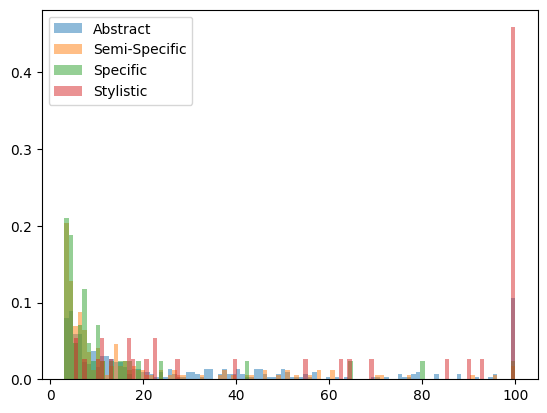

In [40]:
for c in clens:
    plt.hist(clens[c], bins=100, density=True, alpha=0.5, label=c)
plt.legend()
plt.show()


In [6]:
smallset = fifteen.select(range(10))
smallset.save_to_disk("../data/datastores/wikipedia_docs_debug10")

Saving the dataset (1/1 shards): 100%|██████████| 10/10 [00:00<00:00, 1679.27 examples/s]


In [53]:
wdatafull = pickload("../data/datastores/wikipedia_docs_8chunksparagraph.pkl")
wflat = [item for sublist in wdatafull for item in sublist]

In [55]:
weirdcount = 0
for w in wflat:
    w['text'] = str(w['text'])
    if type(w['id']) != int:
        w['id'] = -1
        weirdcount += 1
print(f"weirdcount: {weirdcount}")

weirdcount: 0


In [ ]:
f2ind = {row['text']: i for i, row in enumerate(wflat)}
wfset = set(row['text'] for row in wflat)

In [61]:
dset12k = Dataset.from_list(wflat[62000:77000])

In [ ]:
dset12k.save_to_disk("../data/datastores/wikipedia_docs_15k")

In [62]:
dset12k.save_to_disk("../data/datastores/wikipedia_docs_15k")
# Dataset.from_list(wflat).save_to_disk("../data/datastores/wikipedia_docs_150k")

Saving the dataset (1/1 shards): 100%|██████████| 15000/15000 [00:00<00:00, 100512.93 examples/s]


In [ ]:
# did the full one in the original notebook, TODO can put this stuff together later into smth reproducible

In [ ]:
qdata = Dataset.load_from_disk("../data/evalsets/distractor_queries_settestdata")
allpos = [r['pos_chunks'] for r in qdata]
allposflat = [item for sublist in allpos for item in sublist]

In [34]:
allinds = [f2ind[item] for item in set(allposflat)]

(array([135., 146., 161., 157., 171., 176., 142., 169., 176., 161., 157.,
        139., 166., 172., 142., 154., 164., 164., 153., 138., 158., 166.,
        153., 157., 159., 145., 139., 157., 172., 162., 167., 146., 161.,
        151., 168., 161., 163., 184., 149., 163., 156., 170., 160., 159.,
        156., 151., 158., 152.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([65036.  , 65244.74, 65453.48, 65662.22, 65870.96, 66079.7 ,
        66288.44, 66497.18, 66705.92, 66914.66, 67123.4 , 67332.14,
        67540.88, 67749.62, 67958.36, 68167.1 , 68375.84, 68584.58,
        68793.32, 69002.06, 69210.8 , 69419.54, 69628.28, 69837.02,
        70045.76, 70254.5 , 70463.24, 70671.98

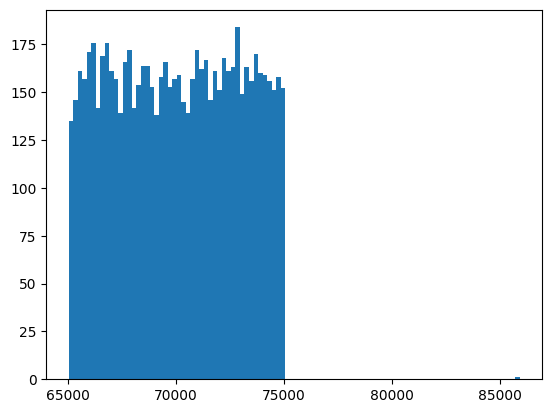

In [35]:
plt.hist(allinds, bins=100)

In [8]:
qdset = Dataset.from_list(qdata)

In [9]:
qdset[0]

{'question': 'Which passage describes a project being revived after a period of political suppression?',
 'goldind': [1354, 1360, 5388, 7755],
 'pos_chunks': ['The Kharkiv School of Photography (KSOP) () is a Ukrainian artistic photography movement. It was created in opposition to the Soviet socialist realism art style, which reigned from 1934 until the 1980s. KSOP started to form in the 1960s when artistic photography revived in Kharkiv during the period of the Khrushchev Thaw. KSOP\'s official formation as a non-conformist underground movement was denoted by the establishment of a group by Kharkiv photographers named the Vremia Group 1971; its foundation is considered the sign of the revival of modernist art in Kharkiv.\n\t\nThe Vremia Group built upon avant-garde traditions and brought socialist realism dogmas into play. They are known for extreme experimentations with photography techniques and methods and are credited for inventing and developing a number of them. One of their sig

In [10]:
qdset = qdset.remove_columns(["goldind", "chunks"])

In [11]:
qdset.save_to_disk("../data/evalsets/distractor_queries_settestdata")

Saving the dataset (1/1 shards): 100%|██████████| 572/572 [00:00<00:00, 1983.24 examples/s]


In [12]:
# for initial gemini indoc data, reformat to have format [query, positive, negative], be broken into train / test split
testdata = Dataset.from_json("../data/colbert_training/gemini_indoc_test.jsonl")
traindata = Dataset.from_json("../data/colbert_training/gemini_indoc_train.jsonl")
testdatafilt = Dataset.from_json("../data/colbert_training/gemini_indoc_test_filtered.jsonl")
traindatafilt = Dataset.from_json("../data/colbert_training/gemini_indoc_train_filtered.jsonl")

In [13]:
testdatafilt

Dataset({
    features: ['query', 'pos', 'neg', 'category', 'rephrased_query'],
    num_rows: 2993
})

In [14]:
def reformat_data(row):
    return {
        "query": row['rephrased_query'] if "rephrased_query" in row else row["query"],
        "positive": row["pos"][0],
        "negative": row["neg"][0]
    }

testdata = testdata.map(reformat_data).remove_columns(["pos", "neg", "posind"])
traindata = traindata.map(reformat_data).remove_columns(["pos", "neg", "posind"])
testdatafilt = testdatafilt.map(reformat_data).remove_columns(["pos", "neg", "category", "rephrased_query"])
traindatafilt = traindatafilt.map(reformat_data).remove_columns(["pos", "neg", "category", "rephrased_query"])

Map:   0%|          | 0/27000 [00:00<?, ? examples/s]

Map: 100%|██████████| 27000/27000 [00:03<00:00, 8432.27 examples/s] 


In [18]:
DatasetDict({"train": traindata, "test": testdata}).save_to_disk("../data/colbert_training/gemini_datav1")
DatasetDict({"train": traindata, "test": testdatafilt}).save_to_disk("../data/colbert_training/gemini_ntrain_ptest")
DatasetDict({"train": traindatafilt, "test": testdatafilt}).save_to_disk("../data/colbert_training/gemini_ptrain_ptest")

Saving the dataset (1/1 shards): 100%|██████████| 2993/2993 [00:00<00:00, 49833.88 examples/s]


In [28]:
assert all(type(x) == str for x in testdata["negative"])